# An example bimodal model with individual effects
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 07 30

MODIFIED:&emsp; James Foster &emsp; 2025 10 21

DESCRIPTION:&emsp; Simulates a bimodal dataset and fits a hierarchical maximum-likelihood von Mises.
Modified from [circular_regression.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   None
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- Simplified
- Tested heavy-tailed distribution for $\kappa_\mu$
- Removed sorting from individual $\mu$
- Still unable to get bimodal $\mu$ robust, archiving

REFERENCES:

- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ (in preparation)
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
> - Generate dataset
> - Fit bimodal model
> - Fit bimodal model with hierarchical structure
> - Add random intercepts to simulated data
> - Set priors for all variables
> - Plot predictions
> - Remove unnecessary sections
> - Generate example where hyperparameter is useful
- Comment in detail
- Fix multimodality in hyperparameter example

In [1]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain
##JJF on Mac install "ipywidgets" for Jupyter support of PyMC
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-ok4k9g5b
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13551 sha256=03efa5992c454fba28cb0a9c09322efb0b6561315b8a6e86851cb0058443eedf
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-2yp7vcp6\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-ok4k9g5b'


# Simulate data
Using a von Mises distribution, simulate two samples and then combine them into a single bimodal sample. In this example, the two means are separated by precisely 180° ("axial") and there are is an equal probability (equal numbers) of observations from the distribution centred on each mean ("symmetrical").

In [2]:
import numpy as np
import bambi as bmb
import arviz as az
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import matplotlib.pyplot as plt

from scipy.stats import vonmises, circmean

from unwrap.link.bambi import LINKS
from unwrap.prior import CircularUniformPrior
from unwrap.data import generate_circular_regression_data
from unwrap.link.numpy import inverse_softplus

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

nsamples = int(20) # Number of trials per individual
nind = int(20) # Number of individuals
mnang = np.pi/3 #Position of mean angle in radians (60°)
skappa = 20.0 #Within individual (average) kappa: very strong correlation 
ikappa = 5.0 #Across individual kappa: quite strong correlation 
#set the number of samples per mode
npersample = int(np.round(nind*nsamples/2))#Here there will be roughly equal proportions of data at each mode
#Generate data for mode 1
data1 = generate_circular_regression_data(
    num_samples= npersample,
    x_range=(0, 0),
    mean_intercept=mnang, #mean at 60°
    mean_slope=0,
    conc_intercept= (skappa), #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)
#Generate data for mode 2
data2 = generate_circular_regression_data(
    num_samples= npersample,
    x_range=(0, 0),
    mean_intercept=mnang + np.pi, #mean at 240°
    mean_slope=0,
    conc_intercept=(skappa), #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)
#Combine into a single bimodal sample
data = pd.concat([data1, data2],    ignore_index= True) 
#Rest the index to treat this as a single sample
data.reset_index(drop=True)
#Give each individual a character name (from a–z)
ids = [chr(i) for  i in range(97, 97+nind)] #97 is 'a', 123 is 'z'
#Repeat the individual name for all of its trials
ids = pd.Series( np.repeat( [ids], nsamples, axis = 0 ).flatten()  )
#Set up trial numbers
trl = np.repeat( range(0, nsamples), nind) #replicate trial numbers 1-20
trl = np.sort( trl ) #organise from trial 1 to trial 20
#Combine into a single data frame
df = pd.DataFrame(
    {
        "angles": pd.Series(data['y']) ,
         "Individual": ids,
         'Trial': trl +1
    }, 
)
# Inspect the simulated data frame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

Sampling: [x, y]
Sampling: [x, y]


       angles Individual  Trial
0    1.101005          a      1
1    1.110409          b      1
2    1.237848          c      1
3    1.052322          d      1
4    1.105017          e      1
5    1.331804          f      1
6    0.927763          g      1
7    1.365234          h      1
8    0.644213          i      1
9    1.095633          j      1
10   0.925400          k      1
11   0.818651          l      1
12   1.402616          m      1
13   0.784665          n      1
14   1.032584          o      1
15   0.890705          p      1
16   0.731200          q      1
17   1.072422          r      1
18   0.976478          s      1
19   1.237841          t      1
20   0.841952          a      2
21   0.624010          b      2
22   0.771409          c      2
23   1.141185          d      2
24   1.130738          e      2
25   1.720082          f      2
26   0.675245          g      2
27   1.226799          h      2
28   1.148781          i      2
29   1.079008          j      2
30   1.4

## Add individual intercepts
Sample individual intercepts drawn from a less concentrated von Mises distribution. These are the added to each sample belonging to each individual. In this case, each individual's headings are more highly correlated than headings compared across individuals, as is common in real data.

In [3]:
from unwrap.link.numpy import shifted_modulo
#add individual intercepts
intercept_id = generate_circular_regression_data(
    num_samples=ids.nunique(),
    x_range=(0, 0),
    mean_intercept=0, #mean at 0°
    mean_slope=0,
    conc_intercept=(ikappa), # very weakly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)
intercept_id['Individual'] = [chr(i) for  i in range(97, 97+nind)] #97 is 'a', 123 is 'z'
print(intercept_id)
dfm = pd.merge(left = df, right = intercept_id, on = 'Individual')
# print(dfm)
dfm['RadAngle'] = dfm['angles'] + dfm['y']
dfm['RadAngle'] = dfm['RadAngle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)
df = dfm
print(df)

Sampling: [x, y]


      x         y  mean  concentration Individual
0   0.0  0.107341   0.0       5.006715          a
1   0.0  0.126066   0.0       5.006715          b
2   0.0  0.377222   0.0       5.006715          c
3   0.0  0.010230   0.0       5.006715          d
4   0.0  0.115331   0.0       5.006715          e
5   0.0  1.507138   0.0       5.006715          f
6   0.0  0.095990   0.0       5.006715          g
7   0.0  1.093924   0.0       5.006715          h
8   0.0  0.053532   0.0       5.006715          i
9   0.0  0.742223   0.0       5.006715          j
10  0.0 -0.774389   0.0       5.006715          k
11  0.0  0.096637   0.0       5.006715          l
12  0.0 -0.242257   0.0       5.006715          m
13  0.0 -0.450476   0.0       5.006715          n
14  0.0  0.688542   0.0       5.006715          o
15  0.0 -0.515413   0.0       5.006715          p
16  0.0 -0.029172   0.0       5.006715          q
17  0.0 -0.310532   0.0       5.006715          r
18  0.0 -0.615901   0.0       5.006715          s


## Plot data
Plot each individual separately on a radial plot, with trail number counting out from the centre and direction as angle relative to the centre. Like real-world bearings, there are shown here clockwise from the upwards (North) direction.

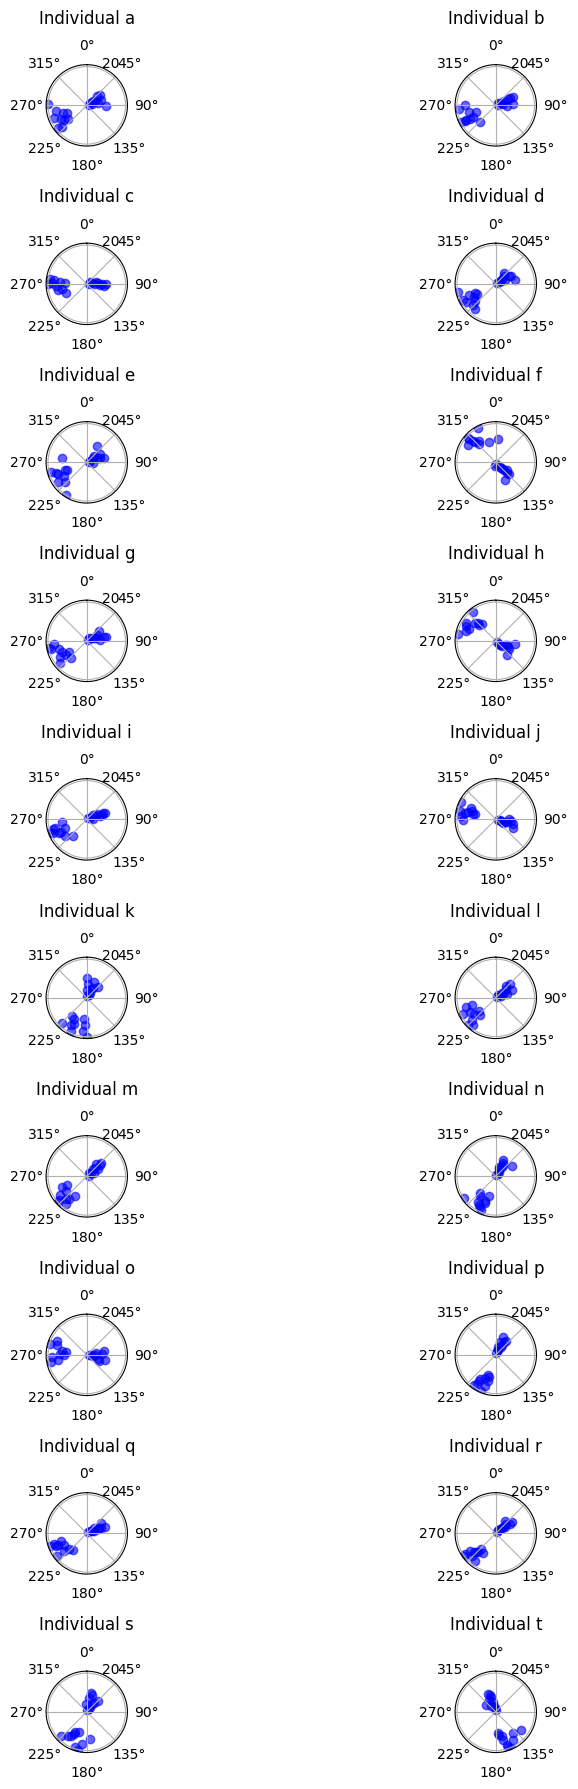

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual Individuals.
unique_individuals = df['Individual'].unique()
# sample_individuals = unique_individuals[np.random.randint(low = 0, high=10, size=6)] # just six chosen randomly
sample_individuals = unique_individuals # all chosen randomly

# Create a grid of polar subplots.
n_plots = len(sample_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = nsamples # Maximum radial value (maximum runs)  # Maximum radial value

# print(df[df['Individual'] == 'a'])

# Plot for each individual.
for idx, individual in enumerate(sample_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise

    individual_data = df[df['Individual'] == individual]
    # print(individual_data.head())
    plotcol = 'blue'        
    plot_scatter(ax, individual_data, 'RadAngle', 'Trial', 
                 plotcol, individual_data)
    #Add expected axis for 2nd trial
    ax.plot(individual_data['RadAngle'].values[0]+[-np.pi, np.pi], [radial_max, radial_max], color='orange', linewidth=1)
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


# Bimodal model
To account for the bimodal distribution, the model needs to include two means ($\mu_1$ & $\mu_2$) for each individual. The associated $\kappa$ values for each can also be estimated and the proportions of the data that each mean is associated with (adds up to 100%). Like for a unimodal model, the means are estimated on the real line via the circular modulo link and kappa is estimated via the softplus link. Since the proportions around each mean (its "weight") must fall in $[0,1]$ these are estimated on the logit scale. To keep the two means separable (identifiable), we sort them from most negative to most positive.

In [5]:
from unwrap.link.numpy import inverse_softplus
#build pymc model equivalent to Sayin et al.
## my comments are labelled like this
# Define the data based on merged_df

## prepare the data
#vector of angles for pymc
directions = df['RadAngle'].values

## convert from names to numbers
# individuals = df['Individual'].values.astype(np.int32)
individuals, uniques = pd.factorize(df['Individual'])#returns the index in the unique values vector, and the unique values vector
## pymc will only accept integers, convert tuple to integer entrywise
individuals = pd.Series(individuals).apply(lambda x: np.int32(x))
num_individuals = df['Individual'].nunique()

# Define the model
## currently uses same priors as Sayin et al., only the mean has a more specific prior and kappa has a less restrictive one
with pm.Model() as hierarchical_directional_model:

    # Population mean angle in radians, bounded between -π and π
    ## propose a narrow starting range
    mu_pop_norm = pm.Normal("mu_pop_norm", mu= [0.0, np.pi], sigma = 0.7*np.pi) # estimates within one rotation of 0° & 180°
    ## set up a pair of angles
    # mu_pop_unsorted =   pm.VonMises("mu_pop_unsorted", mu= mu_pop_norm+[0.0, np.pi], kappa = 1.0, shape=(2,))  # loose vM on separation of means
    mu_pop_unsorted =   pm.VonMises("mu_pop_unsorted", mu= mu_pop_norm+[0.0, 0.0], kappa = 3.0, shape=(2,))  # loose vM on any means
    ## these angles are sorted so that they can later be interpreted as samples from two separate means
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    # Individual mean angles with a Von Mises distribution, adjusted by the population mean
    ## Individual means are drawn from a von Mises distribution centred on 0°, and added to the two estimates from the population
    # mu_unsorted = pm.VonMises("mu_unsorted", 
    #                           mu=0, 
    #                           kappa=30,#expect high correlation 
    #                           shape=(num_individuals, 2)
    #                           ) + mu_pop_unsorted #broadcast to the same shape through addition
    mu_sorted = pm.VonMises("mu_sorted", 
                              mu=0, 
                              kappa=30,#expect high correlation 
                              shape=(num_individuals, 2)
                              ) + mu_pop #broadcast to the same shape through addition
   ## these estimates are then sorted to separate the two means 
    # mu = pm.Deterministic("mu", pt.sort(mu_unsorted))
    mu = pm.Deterministic("mu", mu_sorted)

    # Population kappa values with a softplus transformation for non-negativity
    # for this data need less restrictive prior
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(3.0), sigma=3.0, shape=(2,))
    kappa_pop = pm.Deterministic("kappa_pop", pt.softplus(kappa_log_pop))

    # Individual kappa values, also transformed for non-negativity
    kappa_log = pm.Normal("kappa_log", mu=0.0, sigma=1.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=1.0)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=0.5, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)

In [6]:
#takes over one minute to initialise
#less than 90s to sample
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hierarchical_directional_model:
        trace = pm.sample(tune = 1000,
                            draws = 1000, 
                            return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_norm, mu_pop_unsorted, mu_sorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    trace, 
    var_names=["mu_pop",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
                "kappa_log_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ],
    circ_var_names=["mu_pop",
                    # "mu_unsorted"
                    ]
)
#NB mean should be around 60° = 1.05

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop[0],-2.063,0.109,-2.267,-1.884,0.040,0.037,5.0,32.0,2.14
mu_pop[1],1.081,0.107,0.881,1.255,0.039,0.036,5.0,29.0,2.11
kappa_log_pop[0],12.809,2.531,6.533,16.261,0.999,0.741,10.0,15.0,1.29
kappa_log_pop[1],13.755,1.509,10.990,16.630,0.065,0.048,585.0,2858.0,1.01
weights_logit_pop,0.013,0.161,-0.319,0.297,0.020,0.014,65.0,126.0,1.04


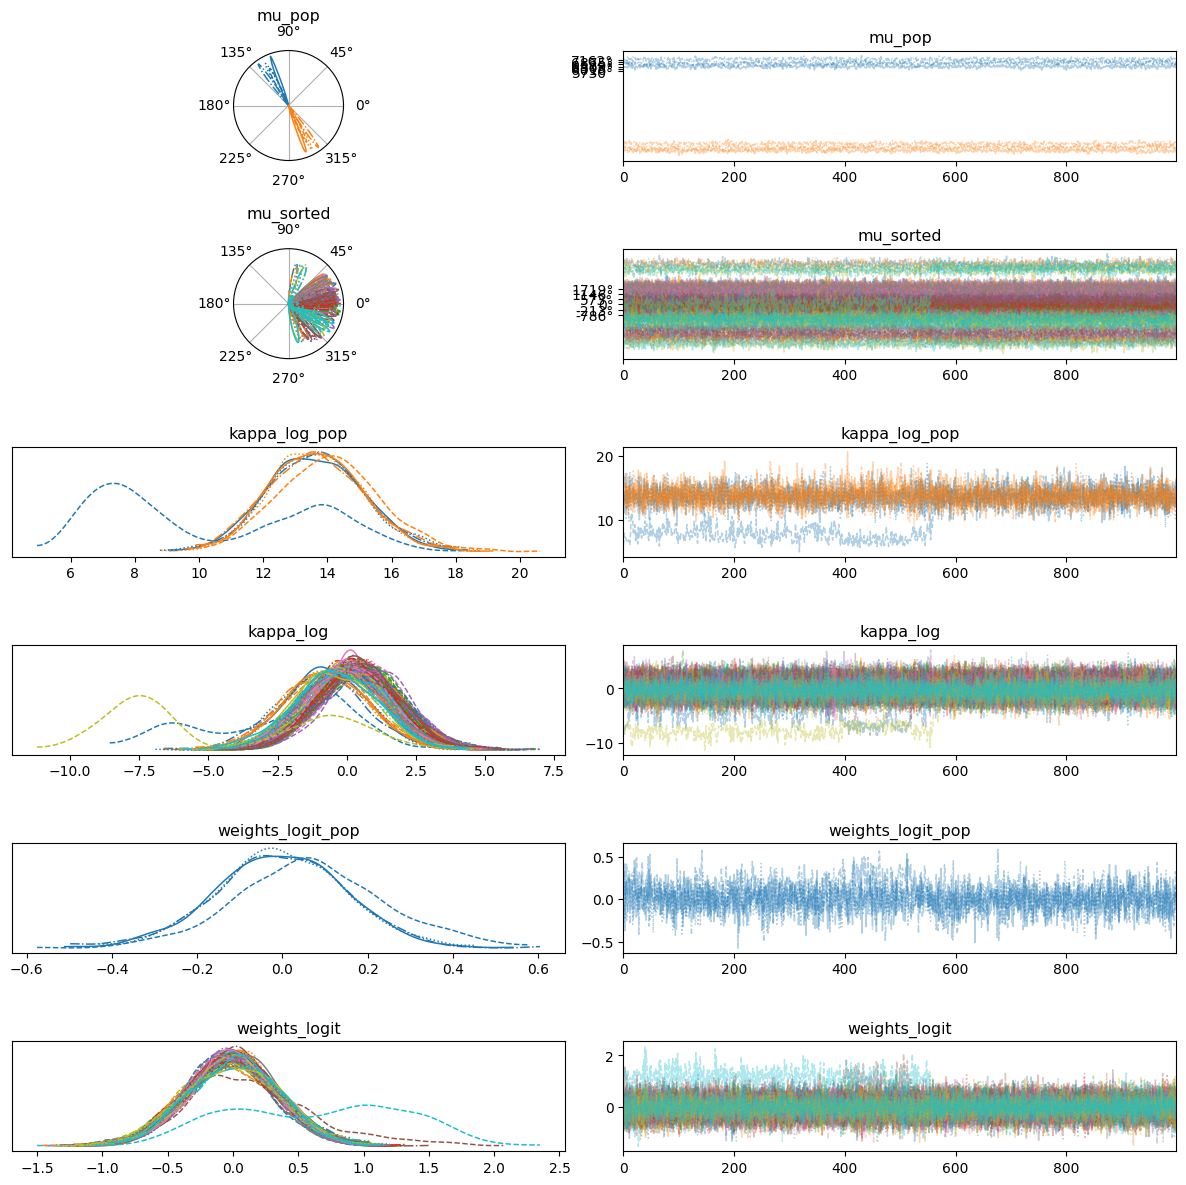

In [8]:
varnms = ["mu_pop",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_sorted",#there are a lot of these, perhaps don't inspect all immediately
                "kappa_log_pop",
               "kappa_log",
               "weights_logit_pop",
               "weights_logit"
                ]
#Specify which parameters are circular
cvars = ["mu_pop",
                    # "mu_unsorted"
                    "mu_sorted"
                    ]
#transform the circular data for interpretability
trace_trans = trace.copy() # set up a variable for transformed data
for cvar in cvars:
    trace_trans.posterior[cvar] = -180*trace_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(trace_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

## Plot the bimodal model
To inspect the fitted model, we can extract the draws and view the predictions alongside the original data.

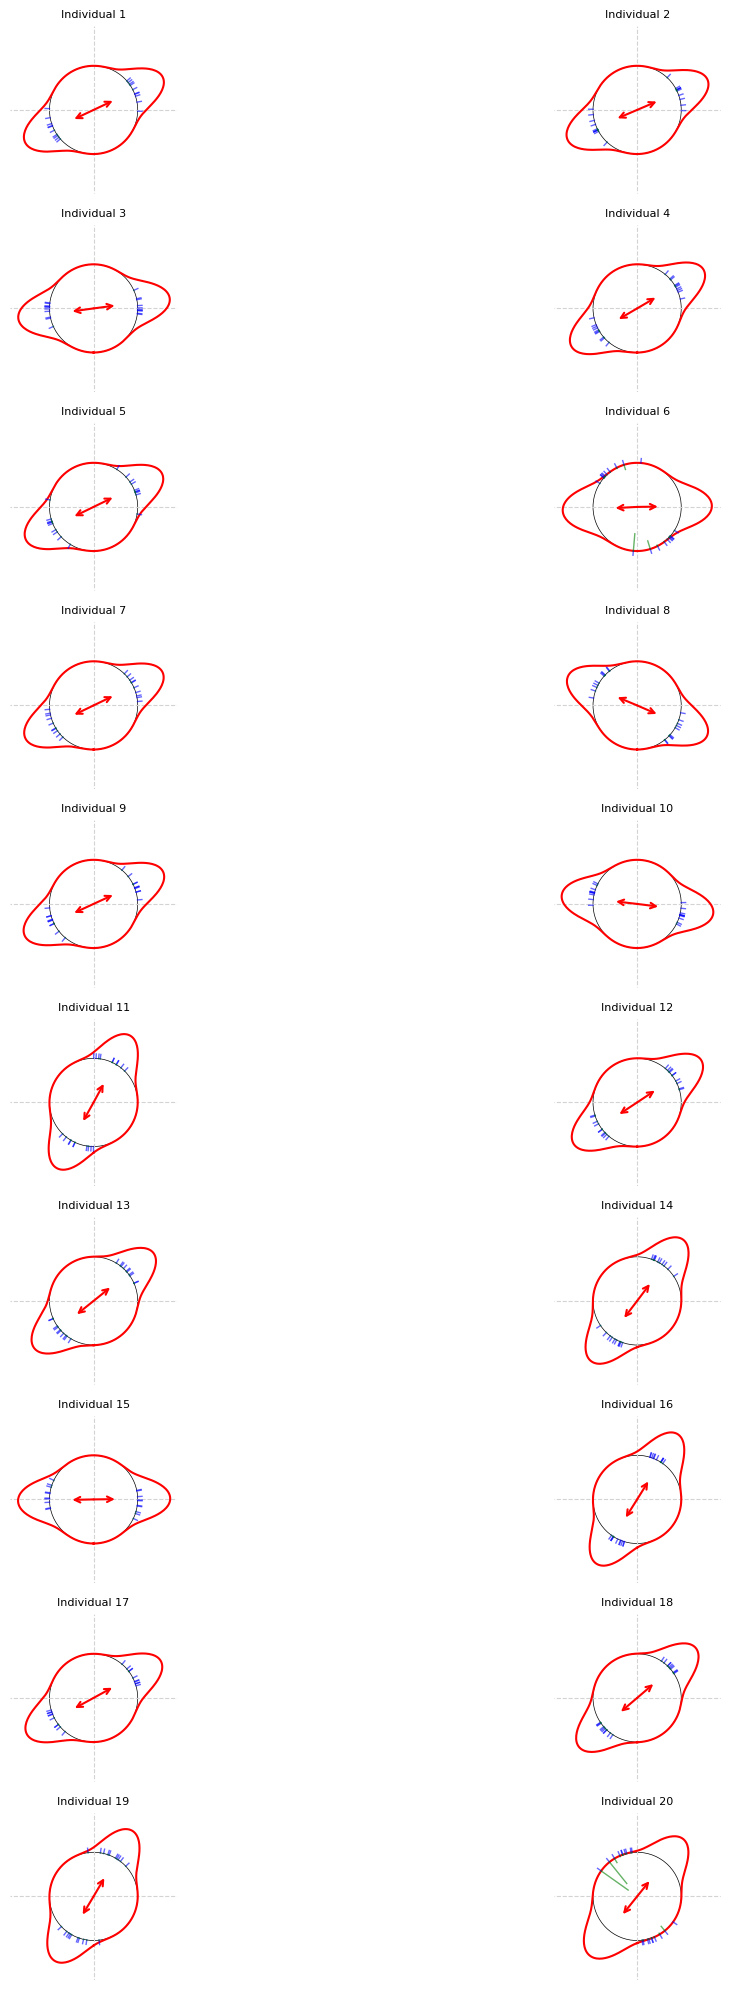

In [9]:
from scipy.special import i0, iv
from matplotlib.patches import Circle, FancyArrow

# Extract posterior samples for population-level parameters
posterior = trace["posterior"]

# Define the angle range for plotting PDFs
angles = np.linspace(-np.pi, np.pi, 360)

# Compute the mean of posterior samples for each individual
mu_mean = posterior["mu"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
kappa_mean = posterior["kappa"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
weights_mean = posterior["weights"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)

# Define the radius for plotting the PDFs and data vectors
edge_radius = 1.0

# Create a figure with subplots for each individual
n_plots = len(sample_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axs = plt.subplots(nrows=n_rows, ncols= n_cols, subplot_kw={'projection': 'polar'}, figsize=(15, 20))
axs = axs.flatten()

# Calculate the global maximum PDF value for consistent scaling
max_pdf_global = 0
for idx, individual in enumerate(np.unique(individuals)):
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)
    
    # Update the global maximum PDF value
    max_pdf_global = max(max_pdf_global, np.max(pdf_values))

# Plot the mixture PDF across the full angle range for normalization
for idx, individual in enumerate(np.unique(individuals)):
    # Set axes to geographic format (clockwise, 0° at the top)
    axs[idx].set_theta_zero_location('N')#place 0° at the top
    axs[idx].set_theta_direction(-1)#reverse to clockwise
    
    # Add light gray lines for main angles (0 to π and π/2 to -π/2)
    axs[idx].plot([0, 0], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi, np.pi], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi / 2, np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([-np.pi / 2, -np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)

    individual_data = directions[individuals == individual]
    
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)

    # Calculate the inverted PDF across the full range and normalize
    inverted_pdf_values = np.exp(-log_pdf_values)
    normalization_factor = np.trapz(inverted_pdf_values, angles)  # Integrate over angles for normalization
    
    # Plot the averaged PDF as a red line around the outer edge
    axs[idx].plot(angles, edge_radius + pdf_values, color="red", linewidth=1.5, label="Posterior Predictive PDF")

    # Plot observed data as short radial lines
    line_length = 0.1  # Length of the lines for observed data
    for angle in individual_data:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + line_length], color="blue", alpha=0.6, linewidth=1)
    
    # Compute mean resultant vector lengths for each mode
    R1 = iv(1, kappa_ind[0]) / iv(0, kappa_ind[0])  # Mode 1
    R2 = iv(1, kappa_ind[1]) / iv(0, kappa_ind[1])  # Mode 2
    
    # Scale arrow lengths by mean resultant vector length and mixture weight
    arrow_length_1 = edge_radius * R1 * weights_ind[0]
    arrow_length_2 = edge_radius * R2 * weights_ind[1]
    
    # Plot arrows for mode means
    axs[idx].annotate(
        '', xy=(mu_ind[0], arrow_length_1), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )
    axs[idx].annotate(
        '', xy=(mu_ind[1], arrow_length_2), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )

    # Calculate residuals for observed data using normalized inverted log-PDF values
    residual_angles = []
    for angle in individual_data:
        # Calculate the log-PDF value at the observed angle using log-sum-exp
        log_pdf_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angle, kappa_ind[0], loc=mu_ind[0])
        log_pdf_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angle, kappa_ind[1], loc=mu_ind[1])
        log_pdf_value = np.logaddexp(log_pdf_component_1, log_pdf_component_2)
        
        # Invert the log-PDF value in log-space
        inverted_log_pdf_value = -log_pdf_value
        
        # Convert back to regular scale for normalization and residual calculation
        inverted_pdf_value = np.exp(inverted_log_pdf_value)
        normalized_inverted_value = inverted_pdf_value / normalization_factor
    
        # Calculate residual as the difference between observed position and normalized inverted value
        residual = edge_radius - (edge_radius + normalized_inverted_value)
        residual_angles.append((angle, residual))
    
    # Plot residuals as short green lines extending from observed data points
    for angle, residual in residual_angles:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + residual], 
                      color="green", alpha=0.6, linewidth=1, linestyle='-', label="Residuals" if idx == 0 else "")
    
    # Add custom circular outline
    outer_circle = Circle((0, 0), edge_radius, transform=axs[idx].transData._b, color="black", fill=False, linewidth=0.5)
    axs[idx].add_artist(outer_circle)

    # Set plot limits and titles with global max PDF scaling
    axs[idx].set_ylim(0, edge_radius + max_pdf_global * 1.2)
    axs[idx].set_title(f"Individual {individual + 1}", fontsize=8)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

    # Remove the default polar frame
    axs[idx].spines['polar'].set_visible(False)
    

# Hide unused subplots
for ax in axs[len(np.unique(individuals)):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Estimating the individual effects hyperparameter
In the example above we assume a tight distribution of individual means (kappa = 20), but it is also possible to estimate this as a hyperparameter on the distribution. This gives us two kappa estimates ($\kappa_i$), one for the average individual and one for the distribution of individual means ($\kappa_\mu$).

In [10]:
from unwrap.link.numpy import inverse_softplus

with pm.Model() as hyper_vm_directional_model:

    mu_pop_norm = pm.Normal("mu_pop_norm", mu= [0.0, np.pi], sigma = 0.5*np.pi) # estimates within half rotations of 0° & 180°
    #this time the prior should be tighter, as we want to distinguish individual differences from population
    # mu_pop_unsorted = pm.VonMises("mu_pop_unsorted", mu = mu_pop_norm + [0.0, np.pi], kappa = 3.0, shape=(2,))  # loose vM on separation of means
    mu_pop_unsorted = pm.VonMises("mu_pop_unsorted", mu = mu_pop_norm + [0.0, 0.0], kappa = 3.0, shape=(2,))  # loose vM on separation of means
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    #We expect the individual means to be similar, but there is a strong possibilty of low agreement
    ## This parameter typically needs constraints to values >-1, otherwise the model may become unidentifiable
    kappa_mu_log = pm.Normal('kappa_mu_log', mu = inverse_softplus(30.0), sigma = 15.0)#expect high correlation, but find low
    # kappa_mu_igamma = pm.InverseGamma('kappa_mu_igamma', alpha = 0.1, beta = 30)#expect high correlation, but find low
    kappa_mu = pm.Deterministic('kappa_mu', pt.softplus(kappa_mu_log))
    # kappa_mu = pm.Deterministic('kappa_mu', kappa_mu_igamma)
    
    # Individual mean angles with a Von Mises distribution, adjusted by the population mean
    #however low mu_kappa is, these are not varying
    # mu_unsorted = pm.VonMises("mu_unsorted", 
    #                             mu = 0, 
    #                             kappa=kappa_mu, #this was set to 30, now not exploring means whatever it is
    #                             shape=(num_individuals, 2)
    #                             ) + mu_pop_unsorted #broadcast to the same shape through addition
    # mu = pm.Deterministic("mu", pt.sort(mu_unsorted))
    mu_sorted = pm.VonMises("mu_sorted", 
                            mu=0, 
                            kappa=kappa_mu, #this was set to 30, now not exploring means whatever it is
                            shape=(num_individuals, 2)
                            ) + mu_pop #broadcast to the same shape through addition
   ## these estimates are then sorted to separate the two means 
    # mu = pm.Deterministic("mu", pt.sort(mu_unsorted))
    mu = pm.Deterministic("mu", mu_sorted)
    #expectation of high agreement within individuals
    # kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(10.0), sigma = 10.0, shape=(2,))
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(3.0), sigma = 3.0, shape=(2,))
    #is this in fact individual kappa?
    kappa_pop = pm.Deterministic("kappa_pop", pt.softplus(kappa_log_pop))

    # Individual kappa values, also transformed for non-negativity
    # kappa_log = pm.Normal("kappa_log", mu=0, sigma=0.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa_log = pm.Normal("kappa_log", mu=0, sigma=1.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    # weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=1.0)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    # weights_logit = pm.Normal("weights_logit", mu=0, sigma=1.0, shape=(num_individuals,)) + weights_logit_pop
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=0.5, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)

In [11]:
#takes over one minute to initialise
#less than 120s for 2000 samples
with hyper_vm_directional_model:
    trace_hyper_vm = pm.sample(tune = 1000,
                            draws = 1000, 
                            return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_norm, mu_pop_unsorted, kappa_mu_log, mu_sorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
#check convergence heuristics
az.summary(
    trace_hyper_vm, 
    var_names=[
               "mu_pop",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "kappa_mu",#
                "kappa_pop",
               "weights_logit_pop",
                ],
    circ_var_names=["mu_pop",
                    ]
)
#NB mean should be around 60° = 1.05
#kappa_mu is far below the simulated value ikappa
#kappa_pop is drawn towards the simulated value skappa

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop[0],-2.015,0.159,-2.325,-1.729,0.021,0.021,29.0,665.0,1.11
mu_pop[1],1.120,0.150,0.823,1.389,0.018,0.015,47.0,637.0,1.08
kappa_mu,3.142,0.615,2.003,4.303,0.009,0.007,5314.0,2283.0,1.00
kappa_pop[0],15.427,1.419,12.836,18.087,0.017,0.013,6705.0,3121.0,1.00
kappa_pop[1],15.401,1.356,12.818,17.877,0.017,0.012,6593.0,3261.0,1.00
weights_logit_pop,-0.003,0.151,-0.271,0.294,0.002,0.002,3872.0,3377.0,1.00


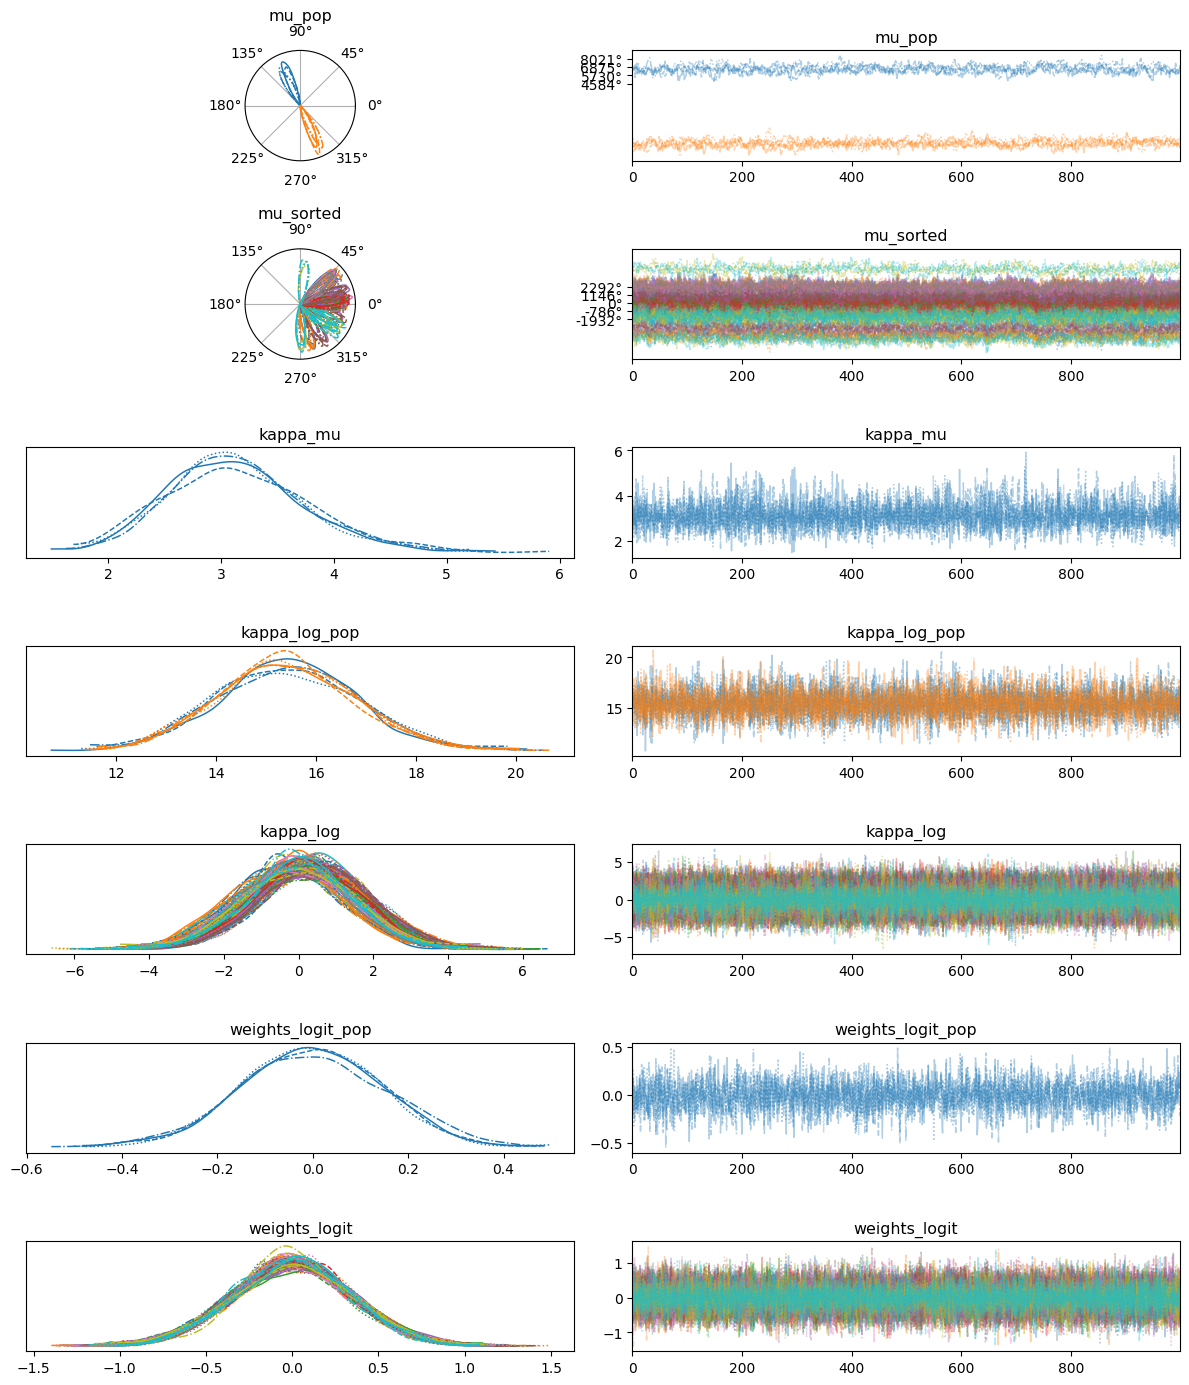

In [13]:
varnms = ["mu_pop",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_sorted",#there are a lot of these, perhaps don't inspect all immediately
               "kappa_mu",
                "kappa_log_pop",
               "kappa_log",
               "weights_logit_pop",
               "weights_logit"
                ]
#Specify which parameters are circular
cvars = ["mu_pop",
        #  "mu_unsorted"
         "mu_sorted"
        ]
#transform the circular data for interpretability
trace_hyper_vm_trans = trace_hyper_vm.copy() # set up a variable for transformed data
for cvar in cvars:
    trace_hyper_vm_trans.posterior[cvar] = -180*trace_hyper_vm_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(trace_hyper_vm_trans,
              var_names= varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

## Plot predictions for von Mises individual effects
To inspect the fitted model, we can extract the draws and view the predictions alongside the original data.

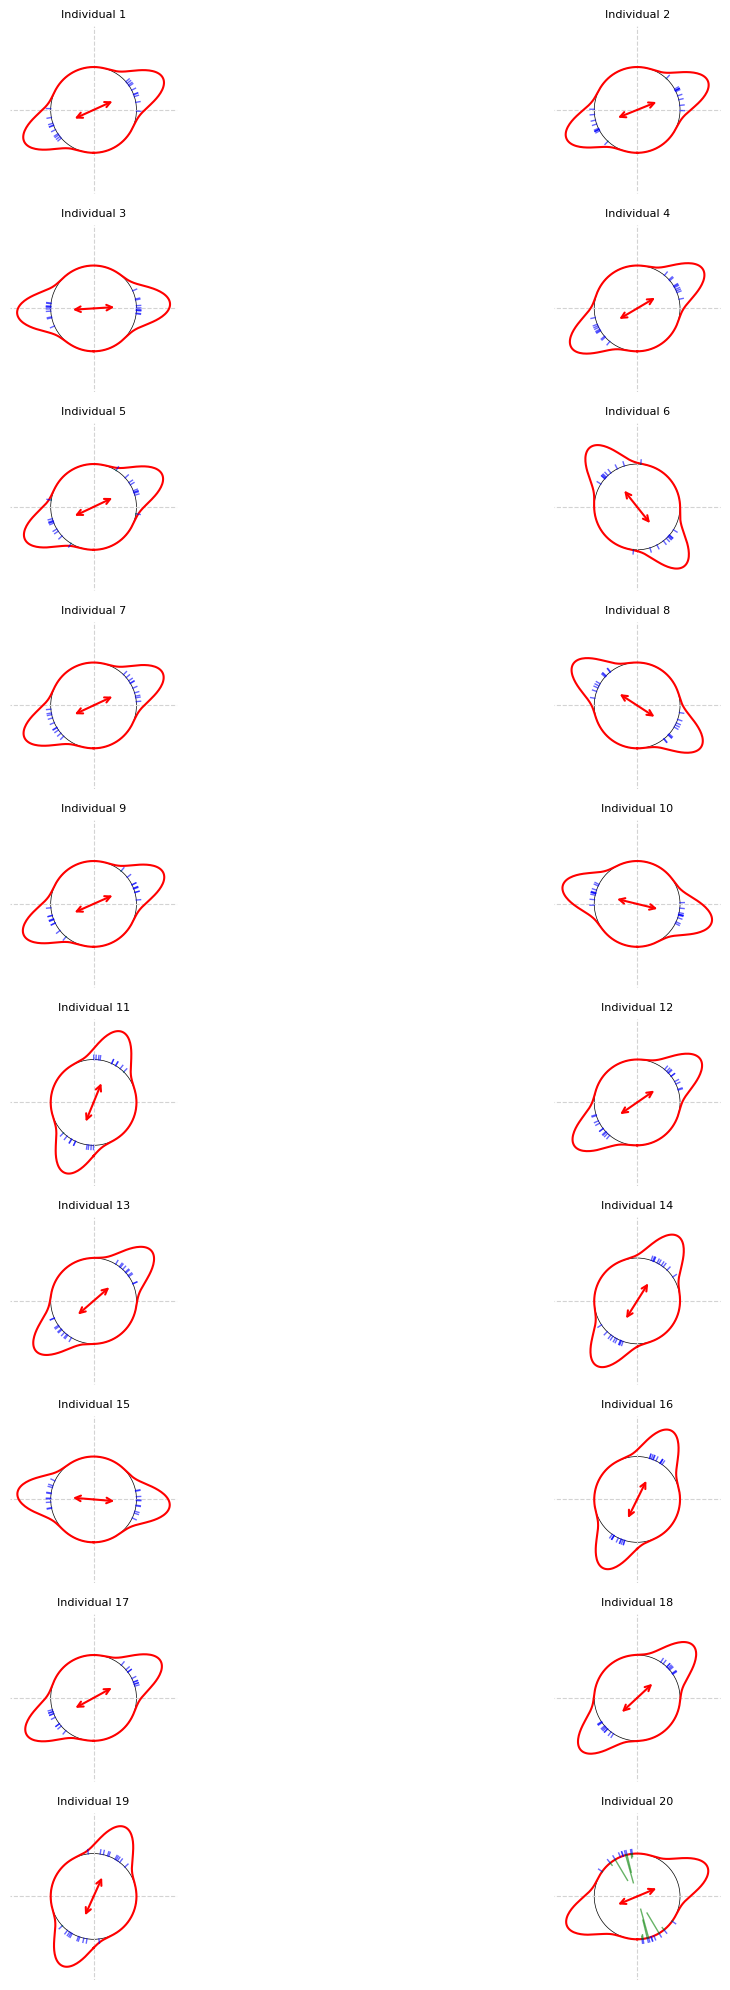

In [14]:
from scipy.special import i0, iv
from matplotlib.patches import Circle, FancyArrow

# Extract posterior samples for population-level parameters
posterior_vm = trace_hyper_vm["posterior"]

# Define the angle range for plotting PDFs
angles = np.linspace(-np.pi, np.pi, 360)

# Compute the mean of posterior samples for each individual
mu_mean = posterior_vm["mu"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
kappa_mean = posterior_vm["kappa"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
weights_mean = posterior_vm["weights"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)

# Define the radius for plotting the PDFs and data vectors
edge_radius = 1.0

# Create a figure with subplots for each individual
n_plots = len(sample_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axs = plt.subplots(nrows=n_rows, ncols= n_cols, subplot_kw={'projection': 'polar'}, figsize=(15, 20))
axs = axs.flatten()

# Calculate the global maximum PDF value for consistent scaling
max_pdf_global = 0
for idx, individual in enumerate(np.unique(individuals)):
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)
    
    # Update the global maximum PDF value
    max_pdf_global = max(max_pdf_global, np.max(pdf_values))

# Plot the mixture PDF across the full angle range for normalization
for idx, individual in enumerate(np.unique(individuals)):
    # Set axes to geographic format (clockwise, 0° at the top)
    axs[idx].set_theta_zero_location('N')#place 0° at the top
    axs[idx].set_theta_direction(-1)#reverse to clockwise
    
    # Add light gray lines for main angles (0 to π and π/2 to -π/2)
    axs[idx].plot([0, 0], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi, np.pi], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi / 2, np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([-np.pi / 2, -np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)

    individual_data = directions[individuals == individual]
    
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)

    # Calculate the inverted PDF across the full range and normalize
    inverted_pdf_values = np.exp(-log_pdf_values)
    normalization_factor = np.trapz(inverted_pdf_values, angles)  # Integrate over angles for normalization
    
    # Plot the averaged PDF as a red line around the outer edge
    axs[idx].plot(angles, edge_radius + pdf_values, color="red", linewidth=1.5, label="Posterior Predictive PDF")

    # Plot observed data as short radial lines
    line_length = 0.1  # Length of the lines for observed data
    for angle in individual_data:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + line_length], color="blue", alpha=0.6, linewidth=1)
    
    # Compute mean resultant vector lengths for each mode
    R1 = iv(1, kappa_ind[0]) / iv(0, kappa_ind[0])  # Mode 1
    R2 = iv(1, kappa_ind[1]) / iv(0, kappa_ind[1])  # Mode 2
    
    # Scale arrow lengths by mean resultant vector length and mixture weight
    arrow_length_1 = edge_radius * R1 * weights_ind[0]
    arrow_length_2 = edge_radius * R2 * weights_ind[1]
    
    # Plot arrows for mode means
    axs[idx].annotate(
        '', xy=(mu_ind[0], arrow_length_1), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )
    axs[idx].annotate(
        '', xy=(mu_ind[1], arrow_length_2), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )

    # Calculate residuals for observed data using normalized inverted log-PDF values
    residual_angles = []
    for angle in individual_data:
        # Calculate the log-PDF value at the observed angle using log-sum-exp
        log_pdf_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angle, kappa_ind[0], loc=mu_ind[0])
        log_pdf_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angle, kappa_ind[1], loc=mu_ind[1])
        log_pdf_value = np.logaddexp(log_pdf_component_1, log_pdf_component_2)
        
        # Invert the log-PDF value in log-space
        inverted_log_pdf_value = -log_pdf_value
        
        # Convert back to regular scale for normalization and residual calculation
        inverted_pdf_value = np.exp(inverted_log_pdf_value)
        normalized_inverted_value = inverted_pdf_value / normalization_factor
    
        # Calculate residual as the difference between observed position and normalized inverted value
        residual = edge_radius - (edge_radius + normalized_inverted_value)
        residual_angles.append((angle, residual))
    
    # Plot residuals as short green lines extending from observed data points
    for angle, residual in residual_angles:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + residual], 
                      color="green", alpha=0.6, linewidth=1, linestyle='-', label="Residuals" if idx == 0 else "")
    
    # Add custom circular outline
    outer_circle = Circle((0, 0), edge_radius, transform=axs[idx].transData._b, color="black", fill=False, linewidth=0.5)
    axs[idx].add_artist(outer_circle)

    # Set plot limits and titles with global max PDF scaling
    axs[idx].set_ylim(0, edge_radius + max_pdf_global * 1.2)
    axs[idx].set_title(f"Individual {individual + 1}", fontsize=8)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

    # Remove the default polar frame
    axs[idx].spines['polar'].set_visible(False)
    

# Hide unused subplots
for ax in axs[len(np.unique(individuals)):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Compare models with and without hyperparameter

In [15]:
#First the log likelihood function needs to be computed for each model
with hierarchical_directional_model:
    pm.compute_log_likelihood(trace)
with hyper_vm_directional_model:
    pm.compute_log_likelihood(trace_hyper_vm)


Output()

Output()

In [16]:
#Calculate predictive power using LOO cross-validation
loo_bimod = az.loo(trace)
loo_hyper = az.loo(trace_hyper_vm)

#print the results
print('\n----- No hyperparameter -----\n')
print(loo_bimod)
print('\n----- Hyperparameter -----\n')
print(loo_hyper)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'No Hyperparameter':loo_bimod,
            'Hyperparameter':loo_hyper}, 
            ic="loo")


----- No hyperparameter -----

Computed from 4000 posterior samples and 400 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -347.89    13.35
p_loo       65.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      400  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


----- Hyperparameter -----

Computed from 4000 posterior samples and 400 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -293.11    11.78
p_loo       44.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      400  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Hyperparameter,0,-293.106767,44.220876,0.00000,1.0,11.777605,0.00000,False,log
No Hyperparameter,1,-347.891547,65.111298,54.78478,0.0,13.349163,6.19519,False,log
